<a href="https://colab.research.google.com/github/Gaurav2912/Cronavirus-Tweet-Sentiment-Analysis/blob/main/Coronavirus_Tweet_Sentiment_Analysis_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sentiment Analysis : Predicting sentiment of COVID-19 tweets</u></b>

## <b> Problem Description </b>

### This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.

### The names and usernames have been given codes to avoid any privacy concerns.

### You are given the following information:
1. Location
2. Tweet At
3. Original Tweet
4. Label

![social-media-marketing-1.jpg](https://dichvuquangcao.vn/wp-content/uploads/2021/04/social-media-marketing-1.jpg)

# **Coronavirus disease**

Coronavirus disease (COVID-19) is an infectious disease caused by the SARS-CoV-2 virus.
Most people who fall sick with COVID-19 will experience mild to moderate symptoms and recover without special treatment. However, some will become seriously ill and require medical attention.


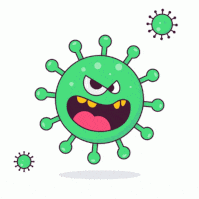

In [1]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Imports the libraries**

In [2]:
# Reading, Exploring and Visulization of the Data
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots

import time
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Importing sklearn libraries for Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# For displaying ploty plot in colab notebook
import plotly.io as pio
pio.renderers.default = "colab"

In [4]:
# path of folder
path = '/content/drive/MyDrive/Colab Notebooks/capstone project/Coronavirus Tweet Sentiment Project/'

# read csv file, utf-8 code error usually comes when the range of numeric values exceeding 0 to 127
# The solution was change the encoding to latin-1
tweet_df = pd.read_csv(path + 'Coronavirus Tweets.csv' , encoding='latin-1')

In [5]:
# showing head of dataframe
tweet_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
# Check the dimension of data drame
tweet_df.shape

(41157, 6)

In [7]:
num_rows = tweet_df.shape[0]
num_cols = tweet_df.shape[1]

print(f"This dataset contains {num_rows} rows and {num_cols} columns.")

This dataset contains 41157 rows and 6 columns.


----
**Confirm quickly with .info() methods the datatypes and null values in our dataframe.**

In [8]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


We have seen that a **TweetAt**  is a string datatype, to extract any information from it, it must first be converted to a **datetime** object.

# Data Cleaning, Preprocessing and Feature engineering.


In [9]:
def add_month(df_name, col_name):
  '''
  Convert the data type of column TweetAt str from  datetime64, 
  and create Month column.
  '''

  df_name[col_name] =  pd.to_datetime(df_name[col_name])
  df_name[col_name + '_month'] = df_name[col_name].dt.month

In [10]:
def map_quarter(month_num):
  '''
  A quarter is a three-month period on a company's financial calendar, this function return quarter of that month.
  '''
  # January, February, and March 
  if month_num <  4: 
    return 'Q1'
  # April, May, and June
  elif month_num < 7:
    return 'Q2'
  # July, August, and September
  elif month_num < 10:
    return 'Q3'
  # October, November, and December 
  return 'Q4'

In [76]:
# To create month columns
add_month(tweet_df, 'TweetAt')

# To create quarter column
tweet_df['Quarter'] =  tweet_df.apply(lambda x : map_quarter(x['TweetAt_month']), axis= 1)

# Create a column that have length of that tweet
tweet_df['Length of tweet'] = tweet_df['OriginalTweet'].apply(len)

In [81]:
# Checking data type of new columns
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   UserName         41157 non-null  int64         
 1   ScreenName       41157 non-null  int64         
 2   Location         32567 non-null  object        
 3   TweetAt          41157 non-null  datetime64[ns]
 4   OriginalTweet    41157 non-null  object        
 5   Sentiment        41157 non-null  object        
 6   TweetAt_month    41157 non-null  int64         
 7   Quarter          41157 non-null  object        
 8   Length of tweet  41157 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 2.8+ MB


In [13]:
# lets check the data frame, for new columns
tweet_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,TweetAt_month,Quarter,length_of_tweet
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,3,Q1,111
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,3,Q1,237
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,3,Q1,131
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,3,Q1,306
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,3,Q1,310


**Get a quick statistical summary of the numeric columns with .describe()**

In [86]:
tweet_df.describe().T

,count,mean,std,min,25%,50%,75%,max
UserName,41157.0,24377.000000,11881.146851,3799.0,14088.0,24377.0,34666.0,44955.0
ScreenName,41157.0,69329.000000,11881.146851,48751.0,59040.0,69329.0,79618.0,89907.0
TweetAt_month,41157.0,4.333673,2.488591,1.0,3.0,3.0,5.0,12.0
Length of tweet,41157.0,204.200160,68.655129,11.0,151.0,215.0,259.0,355.0


* Username and screen name are unique identifiers.
* Minimum length of tweet is 11.
* The length of a single tweet can not exceed 280, but here maximum length is 355.

[ Tweet can contain up to 280 characters or Unicode glyphs](https://developer.twitter.com/en/docs/counting-characters#:~:text=In%20most%20cases%2C%20the%20text,as%20more%20than%20one%20character.)

## Looking for missing values

In [15]:
# conferming null values with diffretnt method 
tweet_df.isna().sum()

UserName              0
ScreenName            0
Location           8590
TweetAt               0
OriginalTweet         0
Sentiment             0
TweetAt_month         0
Quarter               0
length_of_tweet       0
dtype: int64

Since Tweet is a string data, it sometimes gets a null value as a blank space, let's check it out using isspace() method 

In [85]:
tweet_df['OriginalTweet'].str.isspace().sum()

0

In [14]:
# checking for duplicate rows in a Dataframe
sum(tweet_df.duplicated())

0

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

**Insights:**

* No duplicate values found.
* Only location Column have missing values.
* No missing values were found in the OriginalTweets and Sentiment columns.

In [16]:
# Checking for unique values 
tweet_df.nunique().sort_values()

Quarter                4
Sentiment              5
TweetAt_month         12
TweetAt               30
length_of_tweet      329
Location           12220
UserName           41157
ScreenName         41157
OriginalTweet      41157
dtype: int64

# Exploratory data analysis

In [45]:
# set default gridtype, fontsize, figsize and palette
sns.set_style("whitegrid")
sns.set_palette(palette = ['#4169E1', '#FF5F15', '#4CBB17'])
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] =  (8,6)

In [18]:
# Let us see the five unique sentiment of tweets
sentiment_count = tweet_df["Sentiment"].value_counts()
sentiment_count 

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [50]:
# Arrange the sentiments in a particular order
sentiments_order = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative']
sentiment_count = sentiment_count.loc[sentiments_order] 
sentiment_count

Extremely Positive     6624
Positive              11422
Neutral                7713
Negative               9917
Extremely Negative     5481
Name: Sentiment, dtype: int64

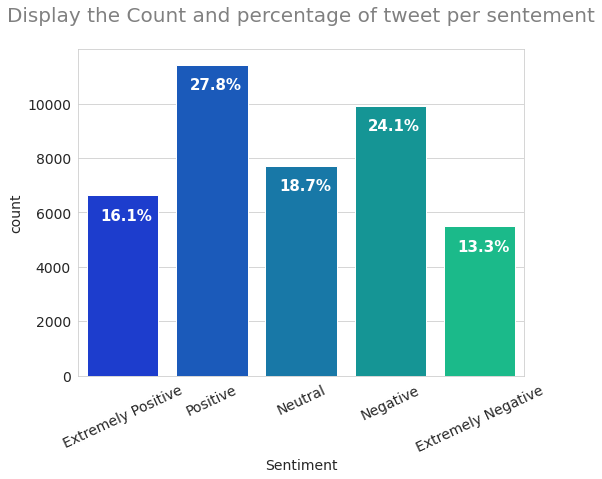

In [62]:
#labels
labels = sentiment_count.index

#values
values = sentiment_count.values

total_tweets = values.sum()          #  oe just len(tweet_df)

for i, value in enumerate(values):
  
  # Calculating the percentage of tweets per sentiments
  percent = 100 * value / total_tweets
  
  # To write text on each bar of the bar plot
  plt.text(x= i- 0.25, y= value - 900,
            s= str(round(percent,1)) + '%', 
           fontsize=15, weight='bold', color= 'white')

# barplot
sns.barplot(x= labels, y = values, palette= 'winter')

# set title, x and y labels 
plt.title('Display the Count and percentage of tweet per sentement\n', size=20, color='grey');
plt.xlabel('Sentiment')
plt.ylabel('count')

# Rotating x-label
plt.xticks(rotation=25);

**Let's see a random tweets from each sentiment**

In [99]:
def sentiment_tweets(sentiment):
    
    '''return a series of that particular sentiment'''  

    # Using conditional selection 
    return tweet_df["OriginalTweet"][tweet_df['Sentiment'] == sentiment]

# Series of Extremely Positive Sentiment tweets
ext_pos_tweets = sentiment_tweets('Extremely Positive')

# Series of Positive Sentiment tweets
pos_tweets = sentiment_tweets('Positive')

# Series of Neutral Sentiment tweets
neut_tweets = sentiment_tweets('Neutral')

# Series of Negative Sentiment tweets
neg_tweets = sentiment_tweets('Negative')

# Series of Extremely Negative Sentiment tweets
ext_neg_tweets = sentiment_tweets('Extremely Negative')

In [119]:
# random integer between 1 to 100
random_num = random.randint(0, 100)

print("Extremely Positive sentiment tweet:\n")
print(ext_pos_tweets.iloc[random_num])
print(120 * '_', end= '\n' * 3)


print("Positive sentiment tweet:\n")
print(pos_tweets.iloc[random_num])
print(120 * '_', end= '\n' * 3)

print("Neutral sentiment tweet:\n")
print(neut_tweets.iloc[random_num])
print(120 * '_', end= '\n' * 3)

print("Negative sentiment tweet:\n")
print(neg_tweets.iloc[random_num])
print(120 * '_', end= '\n' * 3)

print("Extremely Negative sentiment tweet:\n")
print(ext_neg_tweets.iloc[random_num])

Extremely Positive sentiment tweet:



I had spoken to a registered nurse this morning and she was able to answer my questions. Great resource
________________________________________________________________________________________________________________________


Positive sentiment tweet:

FYI: I checked out the freeze dried food companies. Seems everyone is sold out, or out of stock, or backlogged for weeks. #coronavirus
________________________________________________________________________________________________________________________


Neutral sentiment tweet:

Supermarket scene - Posting in foreigners in Finland -group. #covid-19 https://t.co/aYDgVUAcUe
________________________________________________________________________________________________________________________


Negative sentiment tweet:




Employer said: ÂWe need you, weÂre short tonight.Â
________________________________________________________________________________________________________________________


**Histogram for Tweet Length**

In [101]:
fig = px.histogram(tweet_df, x= 'Length of tweet', marginal="box", 
                   title="Histogram for Length of all tweets")

fig.show()

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

>**Insights:**

* The boxplot and histogram show that the length of the tweets is negatively skewed.
* The tallest tower is near 255.
* The second is near 280 as the Twitter official web page shows, which is the maximum limit of charactors in a single tweet.

<br/>

**Let us now see the statistical behavior length of all tweets by sentiment**


In [96]:
# groupby Sentiment, then see statistical information by describe()
tweet_df.groupby('Sentiment')['Length of tweet'].describe()

,count,mean,std,min,25%,50%,75%,max
Sentiment,,,,,,,,
Extremely Negative,5481.0,221.479839,59.985132,14.0,181.0,237.0,271.0,355.0
Extremely Positive,6624.0,228.237470,58.390527,19.0,192.0,241.0,275.0,338.0
Negative,9917.0,203.334174,67.117114,18.0,151.0,212.0,257.0,331.0
Neutral,7713.0,168.160897,72.648841,11.0,109.0,160.0,229.0,325.0
Positive,11422.0,207.056558,66.651587,11.0,156.0,218.0,259.0,350.0


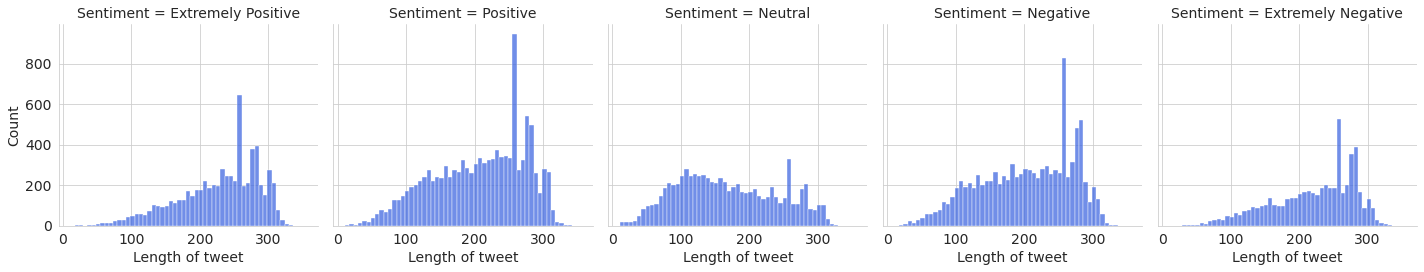

In [97]:
# Histogram of length of all tweets per sentiment
sns.displot(data= tweet_df, x= 'Length of tweet', col= 'Sentiment', col_order= labels, height= 4);

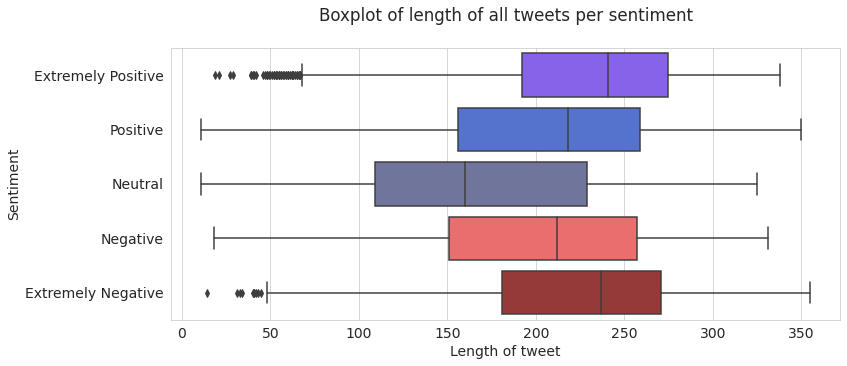

In [98]:
plt.figure(figsize= (12,5))
palette= ['#7C4DFF','#4169E1', '#676FA3', '#FF5959', '#A52A2A']

# Boxplot of length of all tweets per sentiment
sns.boxplot(x= 'Length of tweet', y= 'Sentiment', data= tweet_df, order= labels, orient= 'h',palette= palette)
plt.title('Boxplot of length of all tweets per sentiment\n');

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

>**By looking Histogram and Box-plot**
 
 **The length of :**

  * Neutral sentiment tweet is positively skewed, rest are negatively skewed.
  * Extremely positive and extremely negative sentiments tweets follow the same distribution.
  * Positive and Extremely negative sentiments tweets follow the same distribution.

<br/>

**Let's Explore the Location Feature**

In [105]:
# Top 30 tweets Location
locations = tweet_df['Location'].value_counts() 
locations.iloc[:30]

London                     540
United States              528
London, England            520
New York, NY               395
Washington, DC             373
United Kingdom             337
Los Angeles, CA            281
India                      268
UK                         232
Australia                  225
USA                        223
Canada                     191
England, United Kingdom    191
Toronto, Ontario           160
Global                     159
Chicago, IL                155
California, USA            153
San Francisco, CA          152
Boston, MA                 150
New York, USA              140
New Delhi, India           138
Atlanta, GA                126
New York                   126
Mumbai, India              109
Worldwide                  101
Lagos, Nigeria              99
Houston, TX                 98
Austin, TX                  98
Texas, USA                  98
London, UK                  96
Name: Location, dtype: int64

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

>**Insights:**
  * Lots of locations are repeated, like 
    * London  
    * London, England
    * London, UK 

  * Location is a mix of cities and countries, not contain single feature.

  * As the location suggests, most of the places are from English speaking country or country where people understand English, such as UK, USA, India, Canada, Australia etc., and among of these most of them are also from US and UK.

<br/>

**Donut plot** 
<br/>
location that have more than 100  tweets

In [108]:
#labels
lab = locations[locations>100].keys().tolist()
#values
val = locations[locations>100].values.tolist()

data = go.Pie(labels = lab ,
               values = val ,
               marker = dict(line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )

layout = go.Layout(dict(title = "Location that have more than 100 tweets",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )


fig = go.Figure(data = [data],layout = layout)
iplot(fig)

**Let's analyze tweets per month and quarter**

In [109]:
tweet_df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment', 'TweetAt_month', 'Quarter', 'Length of tweet'],
      dtype='object')

In [110]:
tweet_df.groupby('TweetAt_month')['UserName'].count()

TweetAt_month
1       630
2       954
3     26309
4      2479
5      1131
6      1742
7      1843
8      1881
9      1471
10     1005
11      909
12      803
Name: UserName, dtype: int64

There was a sudden jump in tweets in the month of March when there was an outbreak of Corona, after that the tweet has decreased gradually.

In [116]:
# number of tweets in each quarter
tweet_per_quarter = tweet_df.groupby('Quarter')['UserName'].count()
tweet_per_quarter

Quarter
Q1    27893
Q2     5352
Q3     5195
Q4     2717
Name: UserName, dtype: int64

In [115]:
# number of tweets Sentiment in each quarter
Sentiment_per_quarter= tweet_df.groupby(['Quarter','Sentiment'])['UserName'].count()
Sentiment_per_quarter 

Quarter  Sentiment         
Q1       Extremely Negative    3916
         Extremely Positive    4341
         Negative              6907
         Neutral               5066
         Positive              7663
Q2       Extremely Negative     655
         Extremely Positive     903
         Negative              1247
         Neutral               1056
         Positive              1491
Q3       Extremely Negative     600
         Extremely Positive     910
         Negative              1152
         Neutral               1024
         Positive              1509
Q4       Extremely Negative     310
         Extremely Positive     470
         Negative               611
         Neutral                567
         Positive               759
Name: UserName, dtype: int64

In [120]:
# number of tweet per sentiment in 1st quarter divided by total number of tweet in 1st quarter , then multiplyed by 100 
# gives the percentage of tweet in 1st quarter
100 * Sentiment_per_quarter['Q1']  / tweet_per_quarter['Q1']

Sentiment
Extremely Negative    14.039365
Extremely Positive    15.563044
Negative              24.762485
Neutral               18.162263
Positive              27.472843
Name: UserName, dtype: float64

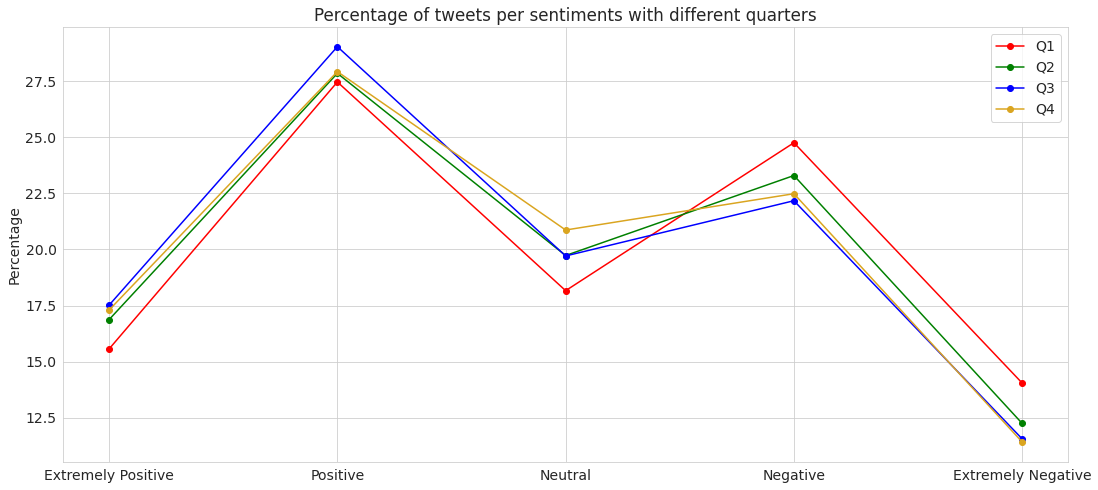

In [123]:
# I will do what I have done above for all quarter and then I plot them

plt.figure(figsize= (18,8))

col = ['#FF0000', '#008000', '#0000FF', '#DAA520']

Q_list = ['Q1', 'Q2', 'Q3', 'Q4']

for i, Q in enumerate(Q_list):
  
  senti_percent =  100 * Sentiment_per_quarter[Q] / tweet_per_quarter[Q]
  
  # sentiments_order is list that we have created above
  senti_percent = senti_percent.loc[sentiments_order]

  # line plot 
  plt.plot(sentiments_order, senti_percent.values, color= col[i], marker= 'o', label = Q)


plt.title('Percentage of tweets per sentiments with different quarters')
plt.ylabel('Percentage')
plt.legend(loc ="upper right");

# correlation check

In [ ]:
tweet_df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment', 'TweetAt_month', 'length_of_tweet', 'Quarter'],
      dtype='object')

In [ ]:
df_objs = tweet_df[['Sentiment', 'Quarter']]
df_objs = pd.get_dummies(df_objs)

In [ ]:
df_final = pd.concat([df_objs, tweet_df['length_of_tweet']], axis= 1)

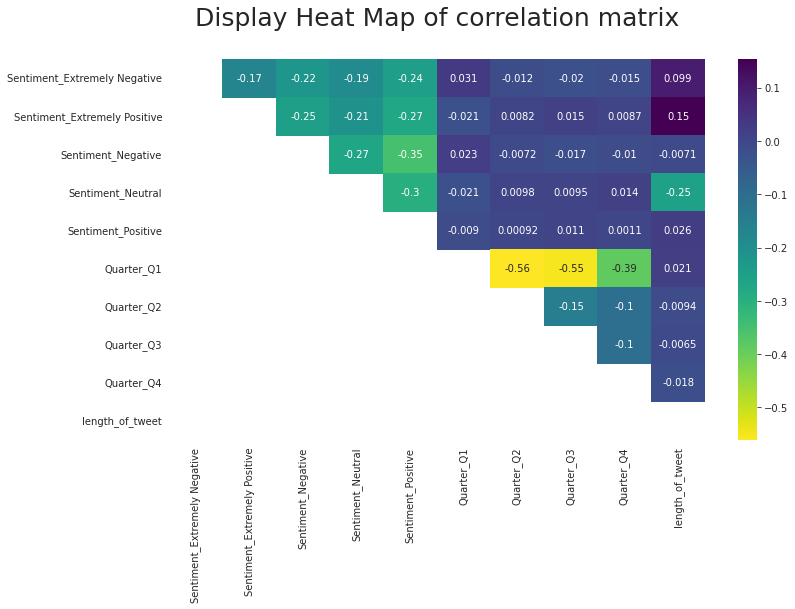

In [ ]:
# for finding correlation matrix , using .corr() method
corr_df = df_final.corr()

plt.figure(figsize= (12,7))

# creating mask for lower triangular matrix
mask = np.tril(np.ones_like(corr_df))

# plotting heat map of correlation matrix
sns.heatmap(corr_df, annot= True, cmap= 'viridis_r', annot_kws={"size":10}, mask= mask)
# add title
plt.title("Display Heat Map of correlation matrix\n", fontsize= 25);

Punctuation
----
Punctuation is the use of spacing, conventional signs, and certain typographical devices as aids to the understanding and correct reading of written text, whether read silently or aloud.

We can use **CountVectorizer** and **tfidf vectorizer** of the scikit-learn library. It by default remove punctuation and lower the documents. It turns each vector into the sparse matrix. It will make sure the word present in the vocabulary and if present it prints the number of occurrences of the word in the vocabulary.

In [ ]:
eng_stop_words = stopwords.words('english')

def text_process(msg):
    
    nopunc =[char for char in msg if char not in string.punctuation]
    nopunc= ''.join(nopunc)
    nostop= [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return ' '.join(nostop)

In [ ]:
# It will take time
tweet_df['tokenized_tweet'] = tweet_df['OriginalTweet'].apply(text_process)

In [ ]:
# Define helper functions
def top_n_words(cv_model, text_data, n_words, plot= False, palette= None):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    matrix = cv_model.fit_transform(text_data)
    freqs = zip(cv.get_feature_names(), matrix.sum(axis=0).tolist()[0])    
    # sort from largest to smallest
    # Top  20 words used in twittws
    tups_of_word = (sorted(freqs, key=lambda x: -x[1])[:n_words])  # -x[1] , negative order

    dict_of_words =   dict(tups_of_word)

    top_words= list(dict_of_words.keys())
    top_values= list(dict_of_words.values())
    
    if plot:
      plt.figure(figsize= (10,6))
      sns.barplot(x= list(dict_of_words.keys()), y = list(dict_of_words.values()), palette= palette)
      plt.ylabel('count')
      plt.title(f"Top {n_words} words")
      plt.xticks(rotation=90);

    else: 
      return top_words, top_values

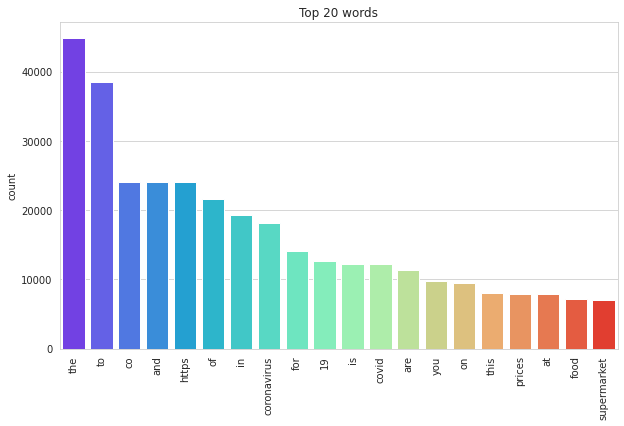

In [ ]:
cv = CountVectorizer()

top_n_words(cv, tweet_df['OriginalTweet'], 20, True, 'rainbow')

In [ ]:
def find_tags(row_string):
    
    # use a list comprehension to find list items that start with #
    tags = [x.replace('#', '') for x in row_string.split() if x.startswith('#')]
    
    tags = set(tags)

    return ' '.join(tags)

In [ ]:
tweet_df['Hashtags'] = tweet_df['OriginalTweet'].apply(find_tags)

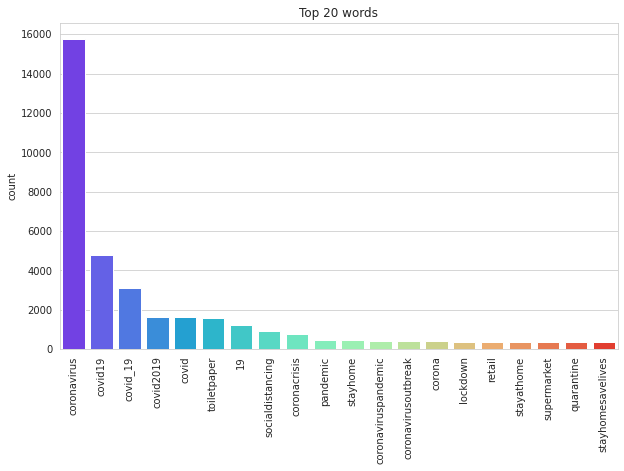

In [ ]:
top_n_words(cv, tweet_df['Hashtags'], 20, True,'rainbow')

StopWord
---
Stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “the”, “is”, “are” and etc. Stop words are commonly used in Text Mining and Natural Language Processing (NLP) to eliminate words that are so commonly used that they carry very little useful information.

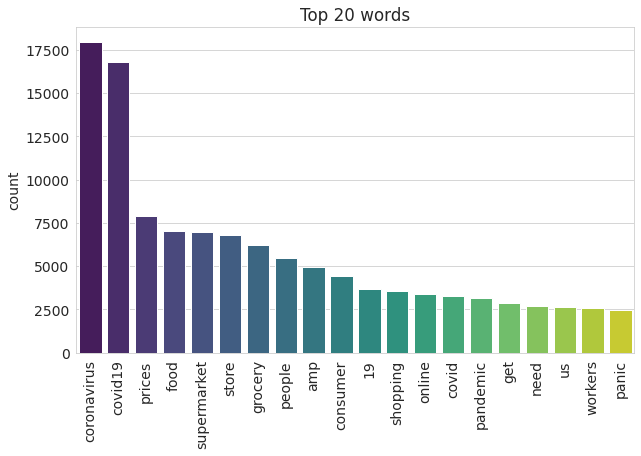

In [ ]:
top_n_words(cv, tweet_df['tokenized_tweet'], 20, True,'viridis')

**Stemming operations**

Stemming operation bundles together words of same root. e.g. stem operation bundles "response" and "respond" into a common "respon"

In [ ]:
# create an object of stemming function
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [ ]:
tweet_df['tokenized_tweet'] = tweet_df['tokenized_tweet'].apply(stemming)

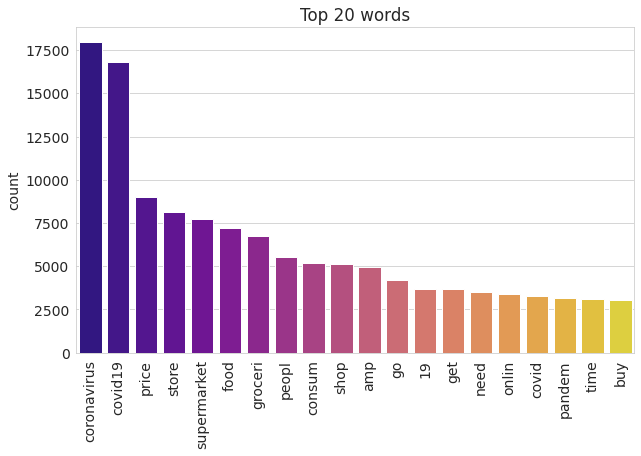

In [ ]:
top_n_words(cv, tweet_df['tokenized_tweet'], 20, True,'plasma')

In [ ]:
tweet_df['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [ ]:
tweet_df['len_tokenized_tweet'] = tweet_df['tokenized_tweet'].apply(len)

In [ ]:
# plt.figure(figsize= (10,6))

# ext_pos_df = tweet_df['tokenized_tweet'][tweet_df['Sentiment'] == 'Extremely Positive']

# plot_top_n_words(cv, ext_pos_df, 20, 'viridis');

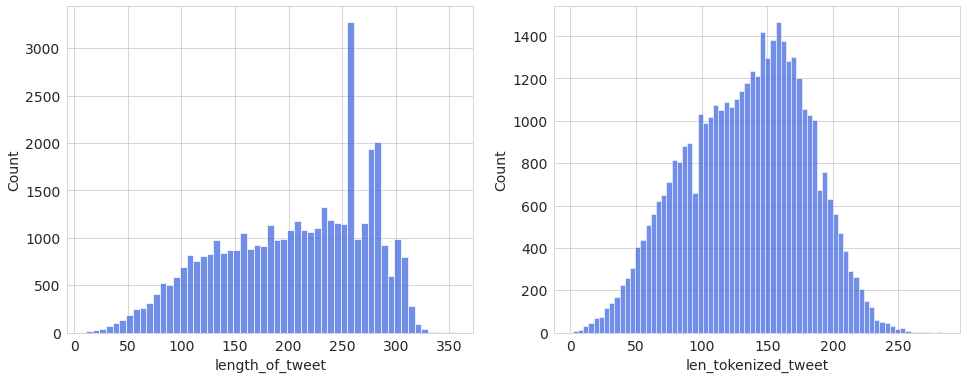

In [ ]:
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize= (16,6))

sns.histplot(data= tweet_df, x= 'length_of_tweet', ax= ax[0])
sns.histplot(data= tweet_df, x= 'len_tokenized_tweet', ax= ax[1]);

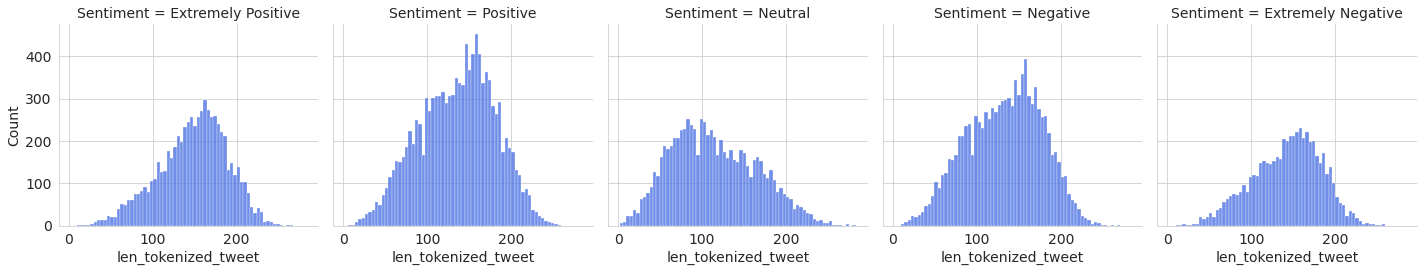

In [ ]:
sns.displot(data= tweet_df, x= 'len_tokenized_tweet', col= 'Sentiment', col_order= labels, height= 4);

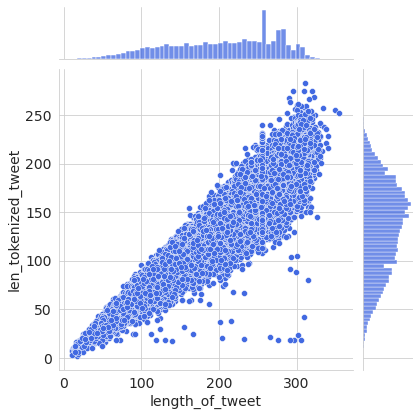

In [ ]:
sns.jointplot(data= tweet_df, x= 'length_of_tweet', y= 'len_tokenized_tweet', kind= 'scatter');

# Word of cloud

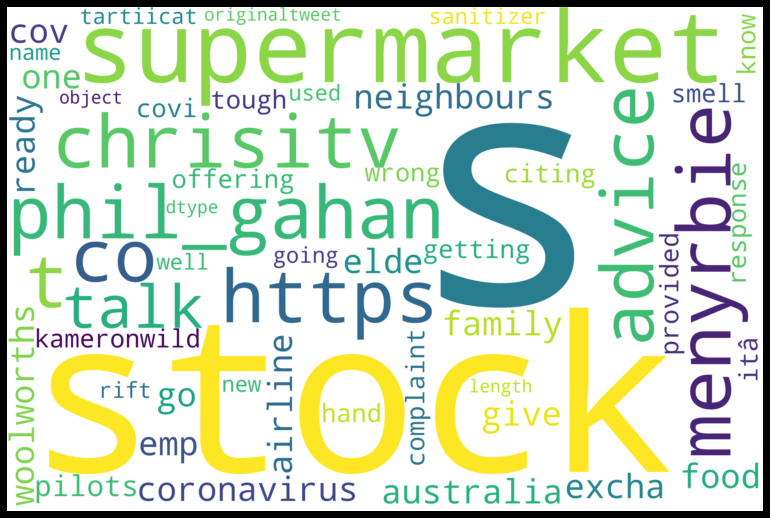

In [ ]:
from wordcloud import WordCloud, STOPWORDS
text = tweet_df['OriginalTweet']

def wordcloud_poster():
  wordcloud = WordCloud(
      width = 3000,
      height = 2000,
      background_color = bg_col,
      stopwords = STOPWORDS).generate(str(text).lower())
  fig = plt.figure(
      figsize = (12,7),
      facecolor = 'k',
      edgecolor = 'k')
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.axis('off')
  plt.tight_layout(pad=0)
  plt.show()

# Model

In [ ]:
tweet_df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment', 'TweetAt_month', 'length_of_tweet', 'Quarter',
       'tokenized_tweet', 'len_tokenized_tweet'],
      dtype='object')

In [ ]:
X = tweet_df['tokenized_tweet']
y = tweet_df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state= 42, stratify= y)

In [ ]:
100 * y_test.value_counts() / len(y_test)

Positive              27.757532
Negative              24.088921
Neutral               18.743926
Extremely Positive    16.095724
Extremely Negative    13.313897
Name: Sentiment, dtype: float64

In [ ]:
100 * y.value_counts() / len(y)

Positive              27.752266
Negative              24.095537
Neutral               18.740433
Extremely Positive    16.094468
Extremely Negative    13.317297
Name: Sentiment, dtype: float64

In [ ]:

tfidf = TfidfVectorizer(max_df = 0.9, min_df = 10)

tfidf.fit(X_train)


X_train_tfidf = tfidf.transform(X_train)

X_test_tfidf = tfidf.transform(X_test)

TfidfVectorizer(max_df=0.9, min_df=10)

In [ ]:
cv_mod = CountVectorizer(max_df = 0.9, min_df = 10)

cv_mod.fit(X_train)
X_train_cv = cv_mod.transform(X_train)

X_test_cv = cv_mod.transform(X_test)

In [ ]:
models = {
    'LogisticRegression': LogisticRegression(),
    # 'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5, p=2),
    'MultinomialNB': MultinomialNB(),
    'LinearSVC': LinearSVC(random_state= 101)
}

In [ ]:
models_data = {
    'Name': [],
    'time_taken': [],
    'train_accuracy': [],
    'test_accuracy': [],
    'trained_model': []
}

for model_name, model_type in models.items():

    print(model_name)

    models_data["Name"].append(model_name)

    tic = time.time()
  
    model_type.fit(X_train_cv, y_train)
    
    
    
    models_data['trained_model'].append(model_type)

    # Training set
    y_pred_train = model_type.predict(X_train_cv)
    train_acc = accuracy_score(y_train, y_pred_train)
    models_data["train_accuracy"].append(train_acc)
 
    # Test set
    y_pred_test = model_type.predict(X_test_cv)
    test_acc = accuracy_score(y_test, y_pred_test)
    models_data["test_accuracy"].append(test_acc)

    tac = time.time()
    models_data["time_taken"].append((tac - tic))

LogisticRegression
MultinomialNB
LinearSVC


In [ ]:
models_info_df = pd.DataFrame(models_data)

In [ ]:
models_info_df

,Name,time_taken,train_accuracy,test_accuracy,trained_model
0,LogisticRegression,5.120085,0.846287,0.600826,LogisticRegression()
1,MultinomialNB,0.172945,0.637844,0.489067,MultinomialNB()
2,LinearSVC,17.991477,0.837479,0.551385,LinearSVC(random_state=101)


In [ ]:
def report(model):
    preds = model.predict(X_test_tfidf)
    print(classification_report(y_test,preds))
    plot_confusion_matrix(model,X_test_tfidf,y_test)
    plt.xticks(rotation= 90)

In [ ]:
sns.set_style('white')

Logistic Regression
                    precision    recall  f1-score   support

Extremely Negative       0.66      0.51      0.58      1096
Extremely Positive       0.68      0.56      0.61      1325
          Negative       0.51      0.53      0.52      1983
           Neutral       0.64      0.63      0.63      1543
          Positive       0.51      0.61      0.56      2285

          accuracy                           0.57      8232
         macro avg       0.60      0.57      0.58      8232
      weighted avg       0.58      0.57      0.57      8232



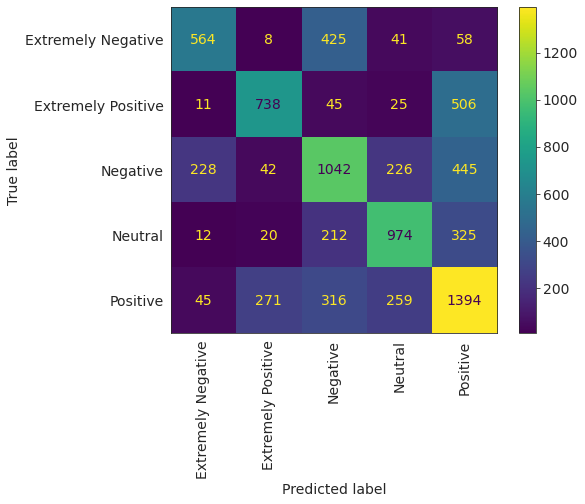

In [ ]:
print('Logistic Regression')
model = models_info_df.loc[0]['trained_model']
report(model)

Linear SVM
                    precision    recall  f1-score   support

Extremely Negative       0.60      0.64      0.62      1096
Extremely Positive       0.60      0.67      0.63      1325
          Negative       0.48      0.44      0.46      1983
           Neutral       0.63      0.61      0.62      1543
          Positive       0.49      0.49      0.49      2285

          accuracy                           0.55      8232
         macro avg       0.56      0.57      0.56      8232
      weighted avg       0.54      0.55      0.55      8232



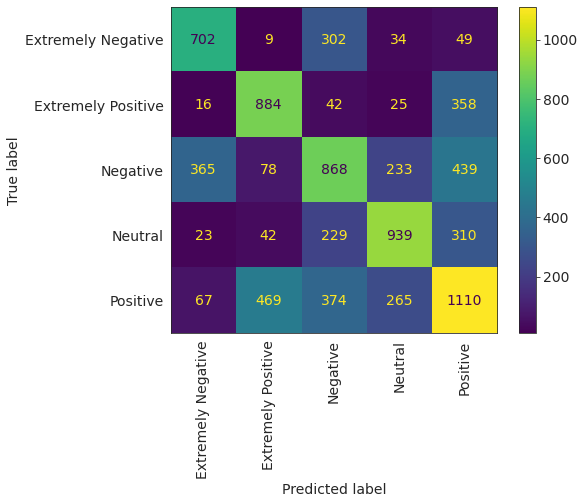

In [ ]:
print('Linear SVM')
model = models_info_df.loc[3]['trained_model']
report(model)